In [8]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [1]:
    model_dict = { 'Scenario 1'   :   'static/feature4096',
                   'Scenario 2'   :   'static/feature4096gap',
                   'Scenario 3'   :   'static/feature8192'}
    

In [3]:
model_dict{1}

SyntaxError: invalid syntax (<ipython-input-3-23d93a20ac74>, line 1)

In [9]:
%matplotlib inline
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Concatenate
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.merge import concatenate
from PIL import Image
from keras.applications.efficientnet import EfficientNetB7
from keras.applications.vgg19 import VGG19, preprocess_input


import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time


class FeatureExtractor:
    def __init__(self):
        vgg_net = VGG19(include_top=False, input_tensor=Input(shape=(128, 128, 3)))
        
        headModel2 = vgg_net.output
        headModel2 = Flatten(name="flatten2")(headModel2)
        headModel2 = Dense(4096, activation='relu')(headModel2)
    
        self.model = Model(inputs=vgg_net.input, outputs=headModel2)
        

    def extract_features(self, img_path):
        im = Image.open(img_path)
        X = preprocess(im,(128,128))
        X = reshape([X])
        
        feat = self.model.predict(X)
        norm_feat = feat[0]/LA.norm(feat[0])
        return norm_feat

In [5]:
import os
import h5py
import numpy as np
import time


'''
 Returns a list of filenames for all jpg images in a directory. 
'''
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]


'''
 Extract features and index the images
'''
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
path = 'CitraBatik_Dataset/train/' 
#path = 'C:/Users/Fadhlan/Temu Kembali Citra/Batik300/' 
img_list = get_imlist(path)

print("--------------------------------------------------")
print("         feature extraction starts")
print("--------------------------------------------------")
start = time.time()

feats = []
names = []

model = FeatureExtractor()
for i, img_path in enumerate(img_list):
    norm_feat = model.extract_features(img_path)
    img_name = os.path.split(img_path)[1]
    feats.append(norm_feat)
    names.append(img_name)
    print("extracting feature from image No. %d , %d images in total" %((i+1), len(img_list)))

feats = np.array(feats)

--------------------------------------------------
         feature extraction starts
--------------------------------------------------
extracting feature from image No. 1 , 250 images in total
extracting feature from image No. 2 , 250 images in total
extracting feature from image No. 3 , 250 images in total
extracting feature from image No. 4 , 250 images in total
extracting feature from image No. 5 , 250 images in total
extracting feature from image No. 6 , 250 images in total
extracting feature from image No. 7 , 250 images in total
extracting feature from image No. 8 , 250 images in total
extracting feature from image No. 9 , 250 images in total
extracting feature from image No. 10 , 250 images in total
extracting feature from image No. 11 , 250 images in total
extracting feature from image No. 12 , 250 images in total
extracting feature from image No. 13 , 250 images in total
extracting feature from image No. 14 , 250 images in total
extracting feature from image No. 15 , 250 ima

extracting feature from image No. 138 , 250 images in total
extracting feature from image No. 139 , 250 images in total
extracting feature from image No. 140 , 250 images in total
extracting feature from image No. 141 , 250 images in total
extracting feature from image No. 142 , 250 images in total
extracting feature from image No. 143 , 250 images in total
extracting feature from image No. 144 , 250 images in total
extracting feature from image No. 145 , 250 images in total
extracting feature from image No. 146 , 250 images in total
extracting feature from image No. 147 , 250 images in total
extracting feature from image No. 148 , 250 images in total
extracting feature from image No. 149 , 250 images in total
extracting feature from image No. 150 , 250 images in total
extracting feature from image No. 151 , 250 images in total
extracting feature from image No. 152 , 250 images in total
extracting feature from image No. 153 , 250 images in total
extracting feature from image No. 154 , 

In [10]:
# directory for storing extracted features


print("--------------------------------------------------")
print("      writing feature extraction results ...")
print("--------------------------------------------------")

output = 'featureCNN-vgg19-2.h5'
h5f = h5py.File(output, 'w')
h5f.create_dataset('feats', data = feats)
h5f.create_dataset('names', data = np.string_(names))
h5f.close()
end = time.time()
print("Cost time: ",end-start," (s)")

--------------------------------------------------
      writing feature extraction results ...
--------------------------------------------------
Cost time:  180.45807814598083  (s)


--------------------------------------------------
               searching starts
--------------------------------------------------


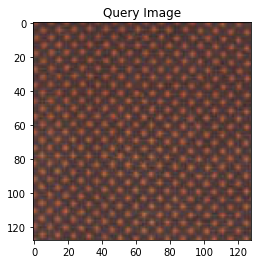

top 5 images in order are:  ['B1', 'B1', 'B1', 'B1', 'B1']


In [12]:
import numpy as np
import h5py
import os
import  matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

h5f = h5py.File('featureCNN-vgg19-2.h5','r')

feats = h5f['feats'][:]
# print(feats)

imgNames = h5f['names'][:]
h5f.close()

print("--------------------------------------------------")
print("               searching starts")
print("--------------------------------------------------")

# read and show query image
queryDir = 'Citrabatik_dataset/test/B1_1.jpg' 
queryImg = mpimg.imread(queryDir)
plt.title("Query Image")
plt.imshow(queryImg)
plt.show()

# init InceptionResNet_V2 model
#model = InceptionResNet_V2()

# extract query image's feature, compute simlarity score and sort
queryVec = model.extract_features(queryDir)
scores = np.dot(queryVec, feats.T)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]


# number of top retrieved images to show
maxres = 5
imlist = [str(imgNames[index]).split("'")[1].split("_")[0] for i,index in enumerate(rank_ID[0:maxres])]
print("top %d images in order are: " %maxres, imlist)

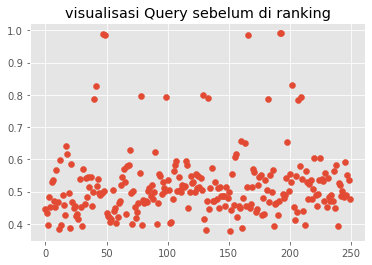

In [30]:
plt.style.use("ggplot")
plt.title("Visualisasi Query sebelum di ranking")
x =rank_ID
y=scores
plt.scatter(x, y)
plt.show()

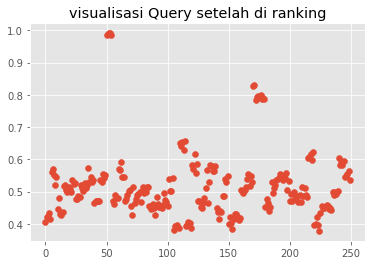

In [31]:
plt.style.use("ggplot")
plt.title("Visualisasi Query setelah di ranking")

x =rank_ID
y=rank_score
plt.scatter(x, y)
plt.show()

In [13]:
kelas_batik = []
presisi_kelas = []
path_test = 'Citrabatik_dataset/test' 
test_list = get_imlist(path_test)
for img_path in test_list:
    queryDir = img_path
    img_name = os.path.split(img_path)[1]
    img_name = img_name.split('_')[0]
    kelas_batik.append(img_name)
    
    queryVec = model.extract_features(queryDir)
    scores = np.dot(queryVec, feats.T)
    rank_ID = np.argsort(scores)[::-1]
    rank_score = scores[rank_ID]

    # number of top retrieved images to show
    maxres = 5
    imlist = [str(imgNames[index]).split("'")[1].split("_")[0] for i,index in enumerate(rank_ID[0:maxres])]
    count = 0
    for list_kelas in imlist:
        if img_name in list_kelas:
            count += 1
    presisi = count / maxres
    presisi_kelas.append(presisi)
    print("top %d images in order are: " %maxres, imlist)

top 5 images in order are:  ['B10', 'B10', 'B10', 'B10', 'B10']
top 5 images in order are:  ['B11', 'B11', 'B11', 'B11', 'B11']
top 5 images in order are:  ['B12', 'B12', 'B12', 'B12', 'B12']
top 5 images in order are:  ['B13', 'B13', 'B13', 'B13', 'B13']
top 5 images in order are:  ['B14', 'B14', 'B14', 'B14', 'B14']
top 5 images in order are:  ['B15', 'B15', 'B15', 'B23', 'B15']
top 5 images in order are:  ['B16', 'B16', 'B11', 'B11', 'B11']
top 5 images in order are:  ['B17', 'B17', 'B17', 'B17', 'B17']
top 5 images in order are:  ['B18', 'B18', 'B18', 'B18', 'B18']
top 5 images in order are:  ['B19', 'B19', 'B19', 'B19', 'B19']
top 5 images in order are:  ['B1', 'B1', 'B1', 'B1', 'B1']
top 5 images in order are:  ['B20', 'B20', 'B20', 'B20', 'B20']
top 5 images in order are:  ['B21', 'B21', 'B21', 'B21', 'B21']
top 5 images in order are:  ['B22', 'B22', 'B22', 'B22', 'B22']
top 5 images in order are:  ['B23', 'B23', 'B23', 'B23', 'B23']
top 5 images in order are:  ['B24', 'B24', 'B

In [14]:
import pandas as pd
df = pd.DataFrame(list(zip(kelas_batik, presisi_kelas)),
               columns =['Kelas', 'precision'])

In [15]:
df

,Kelas,precision
0,B10,1.0
1,B11,1.0
2,B12,1.0
3,B13,1.0
4,B14,1.0
5,B15,0.8
6,B16,0.4
7,B17,1.0
8,B18,1.0
9,B19,1.0


In [16]:
precision = df['precision'].sum()/len(df['precision'])
precision

0.94

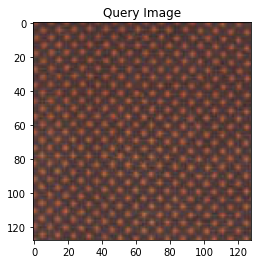

top 5 images in order are:  [b'B1_5.jpg', b'B1_4.jpg', b'B1_3.jpg', b'B1_2.jpg', b'B1_6.jpg']


In [17]:
queryDir = 'Citrabatik_dataset/test/B1_1.jpg'
queryImg = mpimg.imread(queryDir)
plt.title("Query Image")
plt.imshow(queryImg)
plt.show()

queryVec = model.extract_features(queryDir)
scores = np.dot(queryVec, feats.T)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]


# number of top retrieved images to show
maxres = 5
imlist = [imgNames[index] for i,index in enumerate(rank_ID[0:maxres])]
print("top %d images in order are: " %maxres, imlist)

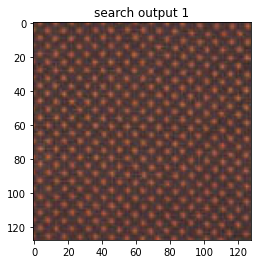

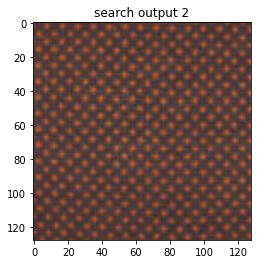

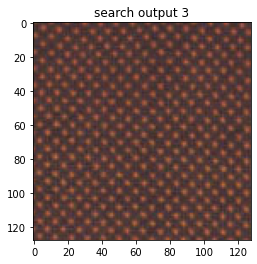

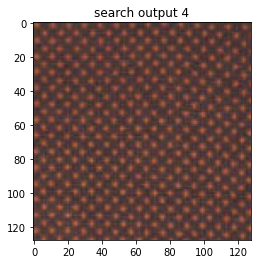

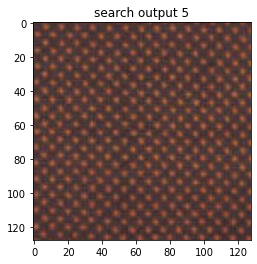

In [18]:
# show top #maxres retrieved result one by one
for i,im in enumerate(imlist):
    image = mpimg.imread(path+"/"+str(im, 'utf-8'))
    plt.title("search output %d" %(i+1))
    plt.imshow(image)
    plt.show()